imports a comprehensive set of libraries commonly used for time series forecasting, particularly with Long Short-Term Memory (LSTM) networks in TensorFlow/Keras.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')
!pip install hydroeval
import hydroeval as he
# Set seeds for all major libraries
import os
import glob
import seaborn as sns
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Current time: 2025-06-25 03:33:34.519450
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


processing hydrological data (stream temperature and flow) along with climate data (temperature) for analysis.

In [2]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
  "13190500"
]

units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)


In [3]:



site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  ]
filtered_df = site_info_df[columns_to_save]

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )

dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)


prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)


prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date','Days_Since_October_1st'
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))

print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

print("df_cleaned:",df_cleaned)

print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

# gap

# Calculate time difference between consecutive dates
df_cleaned['Gap'] = df_cleaned['Date'].diff()

# Filter rows where the gap is more than expected (e.g., > 1 day)
expected_freq = pd.Timedelta(days=1)
gaps = df_cleaned[df_cleaned['Gap'] > expected_freq]

print("gaps",gaps)

site_info_df:   agency_cd   site_no                               station_nm site_tp_cd  \
0      USGS  13190500  SF BOISE RIVER AT ANDERSON RANCH DAM ID         ST   

   lat_va  long_va  dec_lat_va  dec_long_va coord_meth_cd coord_acy_cd  ...  \
0  432037  1152839   43.343611    -115.4775             G            S  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0            NaN   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                    geometry  
0           NaN          NaN         NaN  POINT (-115.4775 43.34361)  

[1 rows x 43 columns]
station_nm: SF BOISE RIVER AT ANDERSON RANCH DAM ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:            tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
8918   -1.199000  13190500 2020-03-01                     151         4.0   
8919   -1.367000  13190500 2020-03-02                     152         4.1   
8920    3.940400 

/tmp/ipython-input-3-928643176.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:


lstm_file_paths = glob.glob('/content/drive/MyDrive/LSTM_DOY/best_KGE_DOY/best_KGE_result_DOY_*.csv', recursive=True)
lstm_file_names = [os.path.basename(path) for path in lstm_file_paths]
lstm_file_names.sort()
print(lstm_file_names)
lstm_csv_path = '/content/drive/MyDrive/LSTM_DOY/best_KGE_DOY/' + lstm_file_names[-1]
lstm = pd.read_csv( lstm_csv_path)

#print(type(lstm['model_site']))
# Filter and display matching site(s)
lstm['model_site'] = lstm['model_site'].astype(str)
print( lstm[lstm['model_site']==model_site[0]])


['best_KGE_result_DOY_202506250201.csv', 'best_KGE_result_DOY_202506250207.csv', 'best_KGE_result_DOY_202506250211.csv', 'best_KGE_result_DOY_202506250216.csv', 'best_KGE_result_DOY_202506250226.csv', 'best_KGE_result_DOY_202506250227.csv', 'best_KGE_result_DOY_202506250233.csv', 'best_KGE_result_DOY_202506250244.csv', 'best_KGE_result_DOY_202506250252.csv', 'best_KGE_result_DOY_202506250253.csv', 'best_KGE_result_DOY_202506250257.csv', 'best_KGE_result_DOY_202506250308.csv', 'best_KGE_result_DOY_202506250320.csv', 'best_KGE_result_DOY_202506250324.csv', 'best_KGE_result_DOY_202506250326.csv', 'best_KGE_result_DOY_202506250330.csv', 'best_KGE_result_DOY_202506250331.csv']
   Unnamed: 0                current_time model_site         train_month   h1  \
0          10  2025-06-25 03:30:03.712012   13190500  [3, 4, 5, 6, 7, 8]  128   

   h2   d1   d2  batch  look_back  ... learning_rate        r2      rmse  \
0  64  0.2  0.1      4         21  ...        0.0001  0.686273  0.368657   

   

In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ,"Days_Since_October_1st"]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#  the minimum of feature is made equal to zero and the maximum of feature equal to one.
scaler_features = MinMaxScaler(feature_range=(0, 1)) # other scalers like StandardScaler (Z-score normalization) might be more appropriate
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned.copy()
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))
print("\nDataFrame after Normalization Head:")
print(df.tail())

(920, 7)
(920, 7)

DataFrame after Normalization Head:
          tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
10558  0.722937  13190500 2024-08-27                0.978142    0.744186   
10559  0.607814  13190500 2024-08-28                0.983607    0.720930   
10560  0.641404  13190500 2024-08-29                0.989071    0.709302   
10561  0.737673  13190500 2024-08-30                0.994536    0.732558   
10562  0.842329  13190500 2024-08-31                1.000000    0.732558   

       00060_Mean    Gap  
10558    0.048342 1 days  
10559    0.042626 1 days  
10560    0.042789 1 days  
10561    0.042300 1 days  
10562    0.042300 1 days  


/tmp/ipython-input-6-3737409037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['Date'] = pd.to_datetime(df_12['Date'])


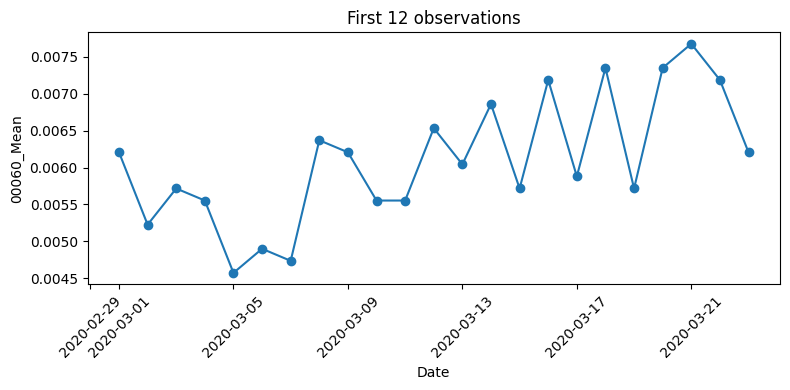

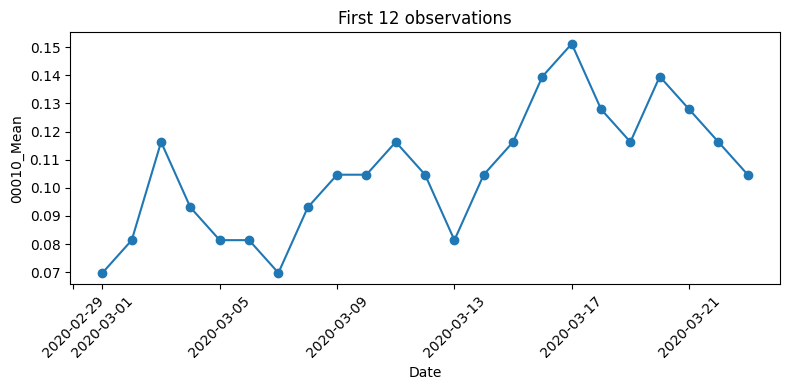

In [6]:
import pandas as pd
#import matplotlib.pyplot as plt

# Assuming your full DataFrame is called `df`
# 1) Keep only the first 12 rows
df_12 = df.head(23)        # or df.iloc[:12]

# 2) Make sure 'Date' is datetime (skip if it already is)
df_12['Date'] = pd.to_datetime(df_12['Date'])

# 3) Plot
plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00060_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00060_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00010_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00010_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back =  21 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.19632916 0.00620611 0.         0.06976744]
 [0.19166214 0.0052262  0.00546448 0.08139535]
 [0.33910138 0.00571615 0.01092896 0.11627907]
 ...
 [0.64140402 0.04278948 0.98907104 0.70930233]
 [0.73767264 0.04229953 0.99453552 0.73255814]
 [0.84232937 0.04229953 1.         0.73255814]]
X [[[0.19632916 0.00620611 0.        ]
  [0.19166214 0.0052262  0.00546448]
  [0.33910138 0.00571615 0.01092896]
  ...
  [0.37907671 0.00734934 0.10382514]
  [0.35417477 0.00767598 0.10928962]
  [0.34109043 0.00718602 0.1147541 ]]

 [[0.19166214 0.0052262  0.00546448]
  [0.33910138 0.00571615 0.01092896]
  [0.30857123 0.00555283 0.01639344]
  ...
  [0.35417477 0.00767598 0.10928962]
  [0.34109043 0.00718602 0.1147541 ]
  [0.35525541 0.00620611 0.12021858]]

 [[0.33910138 0.00571615 0.01092896]
  [0.30857123 0.00555283 0.01639344]
  [0.33729846 0.00457292 0.02185792]
  ...
  [0.34109043 0.00718602 0.1147541 ]
  [0.35525541 0.00620611 0.12021858]
  [0.2867223  0.00636943 0.12568306]]

 ...

 [[0.

In [8]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")
print(f"Y Test samples: {len(Y_test)}")

Train samples: 719
Test samples: 180
 Y Train samples: 719
Y Test samples: 180


In [9]:
print("X_train[0]:", X_train[0])
print("Y_train[0]:", Y_train[0])

print("df.head(6)",df.head(6))


print("Y_train.shape:", Y_train.shape)
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)

X_train[0]: [[0.19632916 0.00620611 0.        ]
 [0.19166214 0.0052262  0.00546448]
 [0.33910138 0.00571615 0.01092896]
 [0.30857123 0.00555283 0.01639344]
 [0.33729846 0.00457292 0.02185792]
 [0.42003823 0.00489956 0.0273224 ]
 [0.33577056 0.00473624 0.03278689]
 [0.28569722 0.00636943 0.03825137]
 [0.28644451 0.00620611 0.04371585]
 [0.32450302 0.00555283 0.04918033]
 [0.33893748 0.00555283 0.05464481]
 [0.25415311 0.00653275 0.06010929]
 [0.22995678 0.00604279 0.06557377]
 [0.33612893 0.00685938 0.07103825]
 [0.3363095  0.00571615 0.07650273]
 [0.36481171 0.00718602 0.08196721]
 [0.36856478 0.00587947 0.08743169]
 [0.26923484 0.00734934 0.09289617]
 [0.32019713 0.00571615 0.09836066]
 [0.37907671 0.00734934 0.10382514]
 [0.35417477 0.00767598 0.10928962]
 [0.34109043 0.00718602 0.1147541 ]]
Y_train[0]: 0.1162790697674419
df.head(6)          tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
8918  0.196329  13190500 2020-03-01                0.000000    0.069767   
891

/tmp/ipython-input-10-1337875955.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([array1, array2],


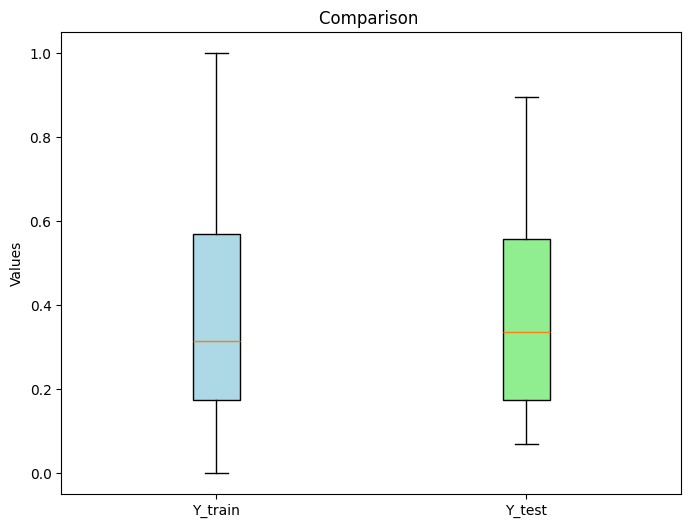

Number of zeros Y_train: 3


In [10]:


#import matplotlib.pyplot as plt
import numpy as np  # Only needed if you're creating example data

# Example data (replace with your actual arrays)
array1 = Y_train
array2 =  Y_test

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create the boxplot
boxplot = plt.boxplot([array1, array2],
                     patch_artist=True,
                     labels=['Y_train', 'Y_test'])

# Customize colors (optional)
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title('Comparison ')
plt.ylabel('Values')

# Show the plot
plt.show()

num_zeros = Y_train.size - np.count_nonzero(Y_train)

print(f"Number of zeros Y_train: {num_zeros}")

In [11]:
model_params = {
    'h1':  128, # 256, #
    'h2':     128 ,#64, #
    'learning_rate': 0.0001,
   'dropout_rate_1': 0.2, #0.1,
   'dropout_rate_2': 0.1 #, 0.05,
   # 'loss_function': 'mean_squared_error',


}

h1 = model_params['h1']
h2 = model_params['h2']
learning_rate = model_params['learning_rate']
d1 = model_params['dropout_rate_1']
d2 = model_params['dropout_rate_2']


In [12]:
# --- 5. Build LSTM Model ---
#learning_rate = 0.0001
optimizer= Adam(learning_rate= learning_rate ) #'adam'
#Adadelta(learning_rate=learning_rate)


model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,297 (778.50 KB)

 Trainable params: 199,297 (778.50 KB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x7aae9b5c5f80>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x7aae9b5c5f80>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x7aae9b5c65c0>


Epoch 1/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0383 - val_loss: 0.0312
Epoch 2/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0185 - val_loss: 0.0260
Epoch 3/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0167 - val_loss: 0.0229
Epoch 4/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0160 - val_loss: 0.0261
Epoch 5/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151 - val_loss: 0.0246
Epoch 6/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0141 - val_loss: 0.0218
Epoch 7/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134 - val_loss: 0.0230
Epoch 8/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0128 - val_loss: 0.0229
Epoch 9/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0132 - val_loss: 0.0238
Epoch 10/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130 - val_loss: 0.0235
Epoch 11/105
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - val_loss: 0.0217
Epoch 12/105
144/144 ━━━━━━━━━━━━━━━━━━━

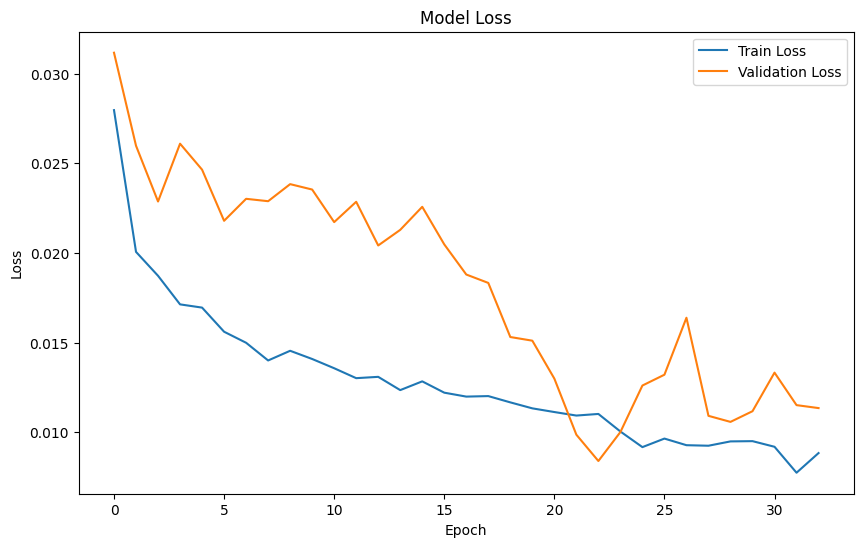

In [13]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  4
history = model.fit(X_train, Y_train,
                    epochs=105, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

#print(history)
# Print the epoch the model stopped at
print(f"Training stopped at epoch: {len(history.history['loss'])}")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,893 (2.28 MB)

 Trainable params: 199,297 (778.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 398,596 (1.52 MB)

In [15]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0091
Test Loss (MSE): 0.0157


In [16]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
all_rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {all_rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Shape of Y_pred_scaled: (180, 1)
Shape of Y_test: (180,)
Shape of X_test: (180, 22, 3)
Test RMSE: 1.0760
Test bias: -0.1831
correlation 0.8542199556991892
2.0276098
1.845763918935584


In [17]:



# Example arrays
x = np.array([1, 2, 3, 4, 5])
print(x.shape)
y = np.array([2, 4, 6, 8, 10])

# Compute the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient (Pearson's r)
correlation_example = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_example)


print("Y_test_original",Y_test_original.shape)
print("Y_test_original",type(Y_test_original) )
print(np.isnan(Y_test_original).sum())
print(np.isinf(Y_test_original).sum())
print("Y_pred",Y_pred.shape)
print("Y_pred",type(Y_pred))
print(np.isnan(Y_pred).sum())
print(np.isinf(Y_pred).sum())

(5,)
Correlation coefficient: 0.9999999999999999
Y_test_original (180, 1)
Y_test_original <class 'numpy.ndarray'>
0
0
Y_pred (180, 1)
Y_pred <class 'numpy.ndarray'>
0
0


In [18]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print("summer_df.tail()",summer_df.tail())


summer_df.to_csv( '/content/drive/My Drive/LSTM_DOY/LSTM_predictions_DOY/'+( model_site[0] + "summer_df.csv") , index=False )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of            tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
8918   -1.199000  13190500 2020-03-01                     151         4.0   
8919   -1.367000  13190500 2020-03-02                     152         4.1   
8920    3.940400  13190500 2020-03-03                     153         4.4   
8921    2.841400  13190500 2020-03-04                     154         4.2   
8922    3.875500  13190500 2020-03-05                     155         4.1   
...          ...       ...        ...                     ...         ...   
10558  17.757401  13190500 2024-08-27                     330         9.8   
10559  13.613300  13190500 2024-08-28                     331         9.6   
10560  14.822449  13190500 2024-08-29                     332         9.5   
10561  18.287849  13190500 2024-08-30                     333         9.7   
10562  22.055199  13190500 2024-08-31                     334         9.7   

       00060_Mean    Gap  
8

/tmp/ipython-input-18-2178870764.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
/tmp/ipython-input-18-2178870764.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
/tmp/ipython-input-18-2178870764.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

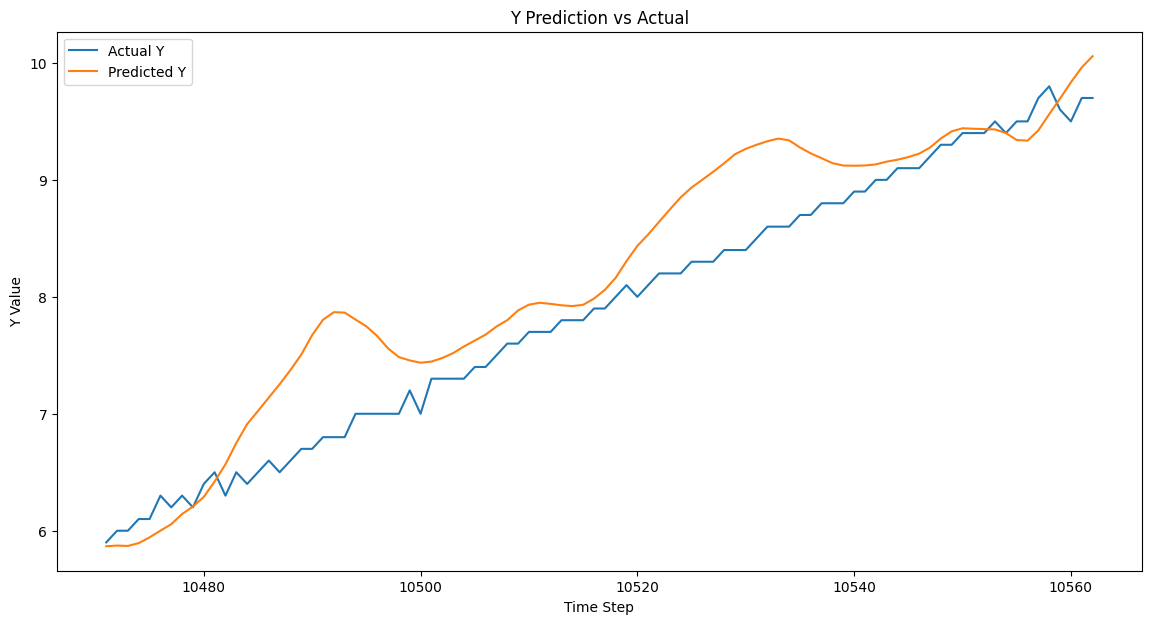

In [19]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

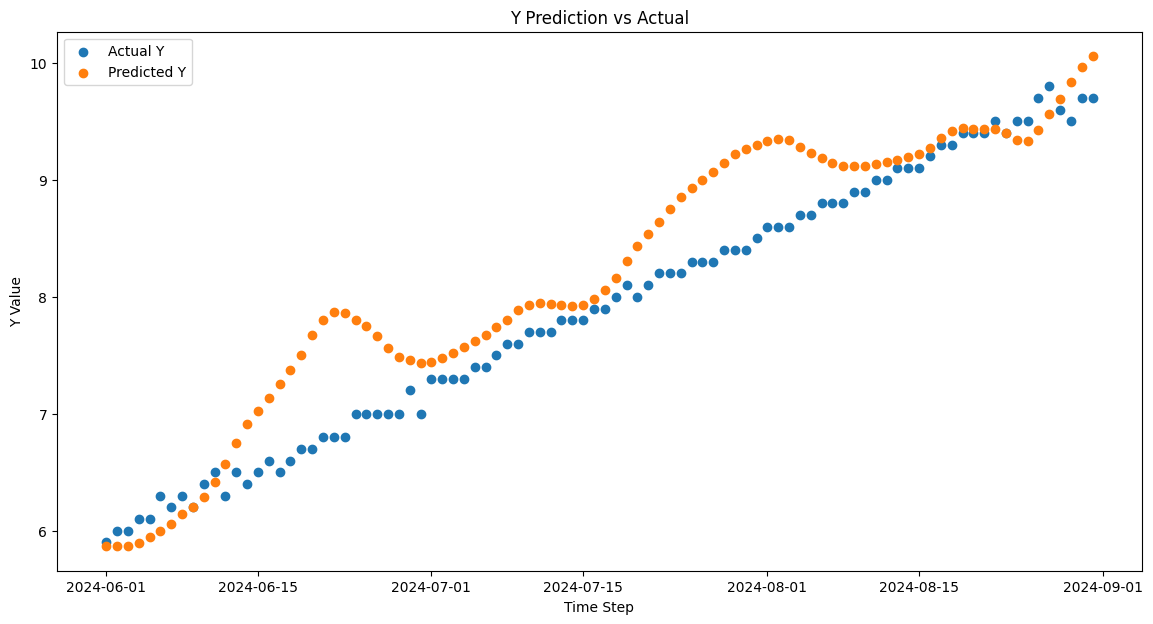

In [20]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

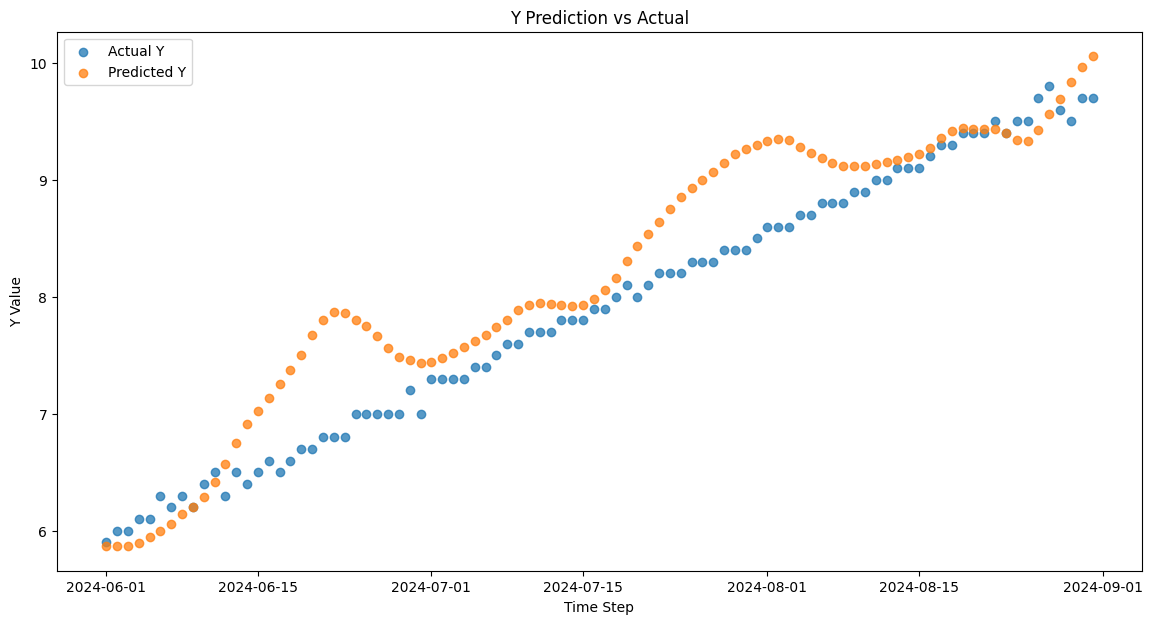

In [21]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

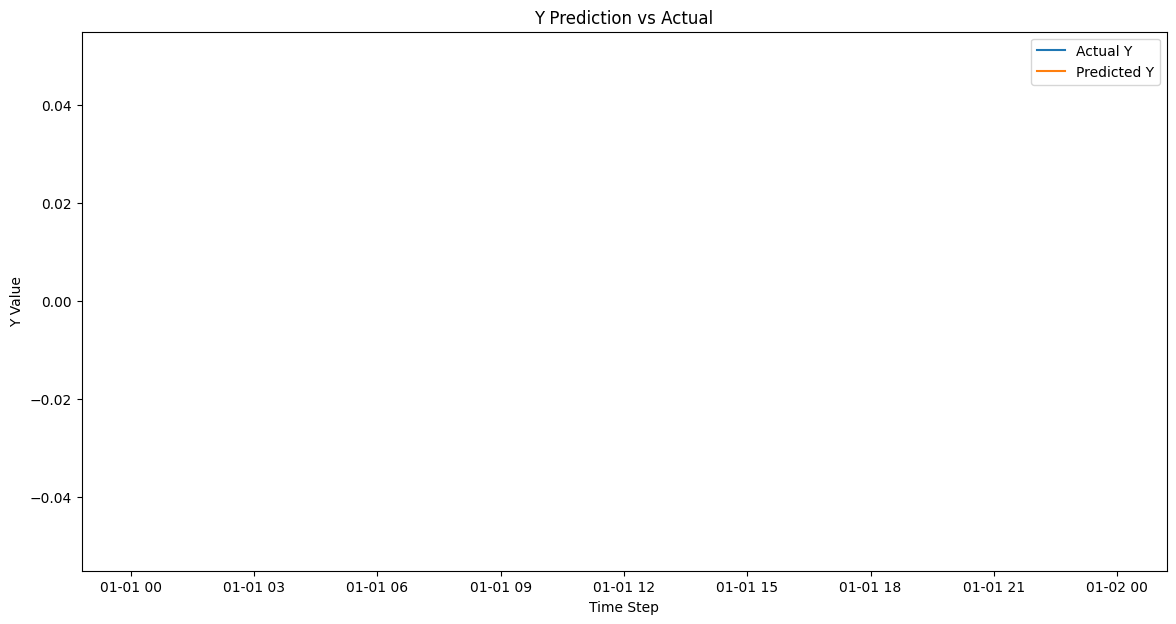

In [22]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

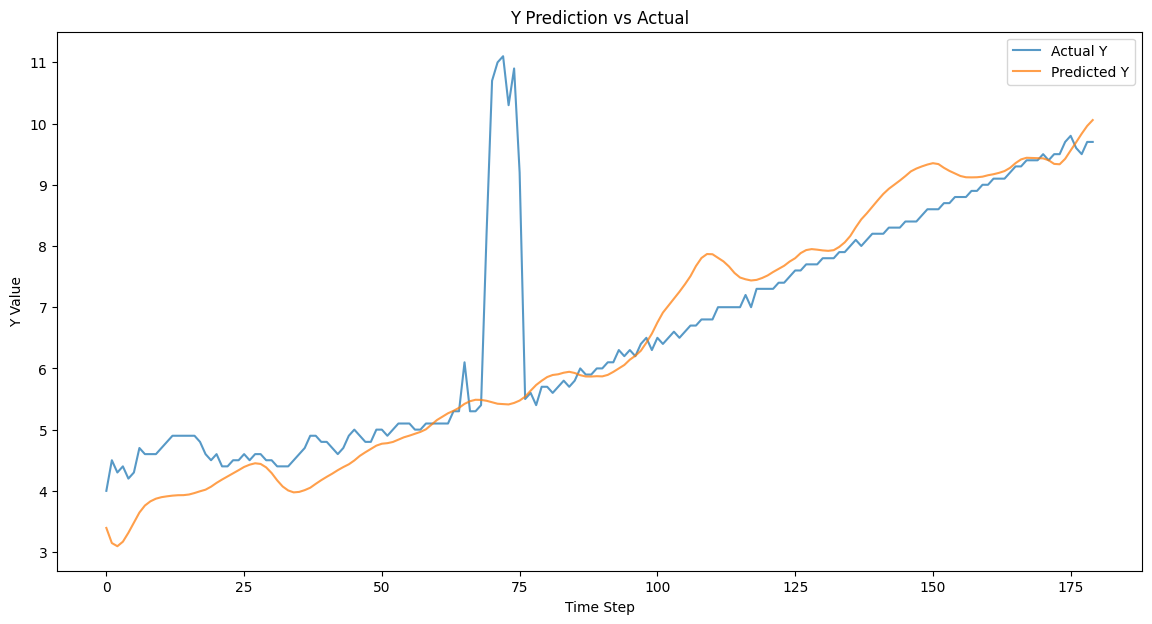

In [23]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()


In [24]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]
                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
    ,"r2" :[r2]
    , "rmse":[rmse]
                           , "bias":[bias]

                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]


    ,"KGE" : [kge_value]
,"KGE_r_comp" : [r_comp]
,"KGE_alpha_comp" : [alpha_comp]
,"KGE_beta_comp" : [beta_comp]
    })

print(result_df)


#result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_DOY/LSTM_results_DOY/' + model_site[0]+'_result_DOY_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


                current_time model_site         train_month   h1   h2   d1  \
0 2025-06-25 03:33:34.519450   13190500  [3, 4, 5, 6, 7, 8]  128  128  0.2   

    d2  batch  look_back                                          optimizer  \
0  0.1      4         21  <keras.src.optimizers.adam.Adam object at 0x7a...   

   learning_rate        r2      rmse      bias  std_ratio  correlation  \
0         0.0001  0.660163  0.457282 -0.183149   1.098521      0.85422   

                    KGE            KGE_r_comp        KGE_alpha_comp  \
0  [0.8219018485486249]  [0.8542199556991893]  [1.0985206744660825]   

          KGE_beta_comp  
0  [0.9724172710414869]  


In [25]:
#model.save( (model_site[0]+'_lstm_model.h5') )

           tmean   site_no       Date  Days_Since_October_1st  00010_Mean  \
10471  14.405549  13190500 2024-06-01                     243         5.9   
10472  15.414749  13190500 2024-06-02                     244         6.0   
10473  11.413800  13190500 2024-06-03                     245         6.0   
10474  14.260349  13190500 2024-06-04                     246         6.1   
10475  17.048750  13190500 2024-06-05                     247         6.1   

       00060_Mean    Gap    Y_pred  Y_test_original      bias  
10471      2000.0 1 days  5.867485              5.9 -0.032515  
10472      2000.0 1 days  5.872944              6.0 -0.127056  
10473      2010.0 1 days  5.869838              6.0 -0.130162  
10474      2010.0 1 days  5.894267              6.1 -0.205733  
10475      2010.0 1 days  5.943326              6.1 -0.156674  


/tmp/ipython-input-26-2963098943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


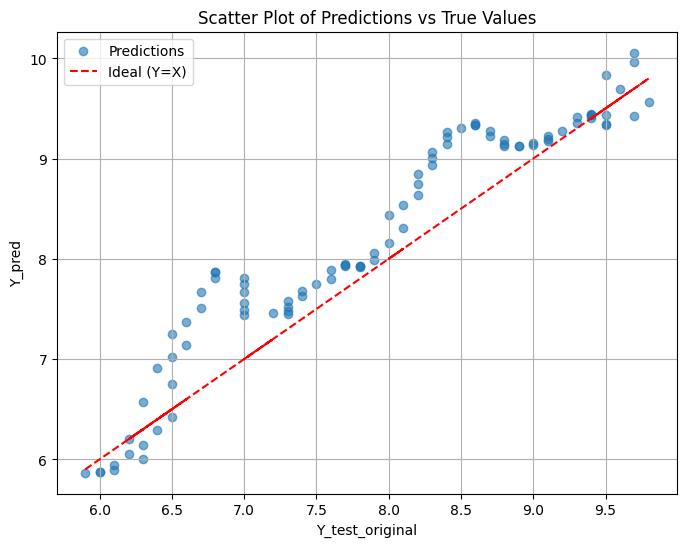

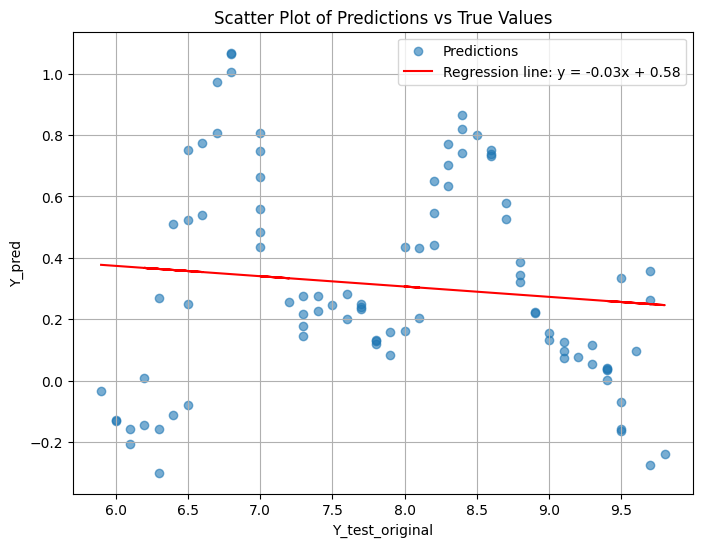

In [26]:
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']
print( summer_df.head() )

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

Locates the peak bias

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, 10471 to 10562
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   tmean                   92 non-null     float64        
 1   site_no                 92 non-null     object         
 2   Date                    92 non-null     datetime64[ns] 
 3   Days_Since_October_1st  92 non-null     int64          
 4   00010_Mean              92 non-null     float64        
 5   00060_Mean              92 non-null     float64        
 6   Gap                     92 non-null     timedelta64[ns]
 7   Y_pred                  92 non-null     float32        
 8   Y_test_original         92 non-null     float64        
 9   bias                    92 non-null     float64        
dtypes: datetime64[ns](1), float32(1), float64(5), int64(1), object(1), timedelta64[ns](1)
memory usage: 7.5+ KB
None
           tmean   site_no       Date  Days_S

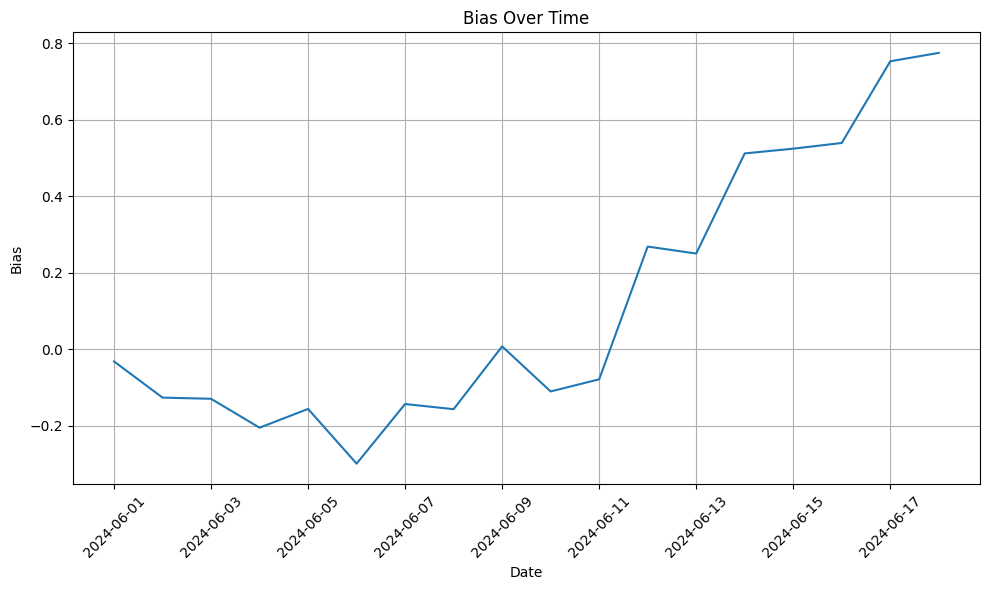

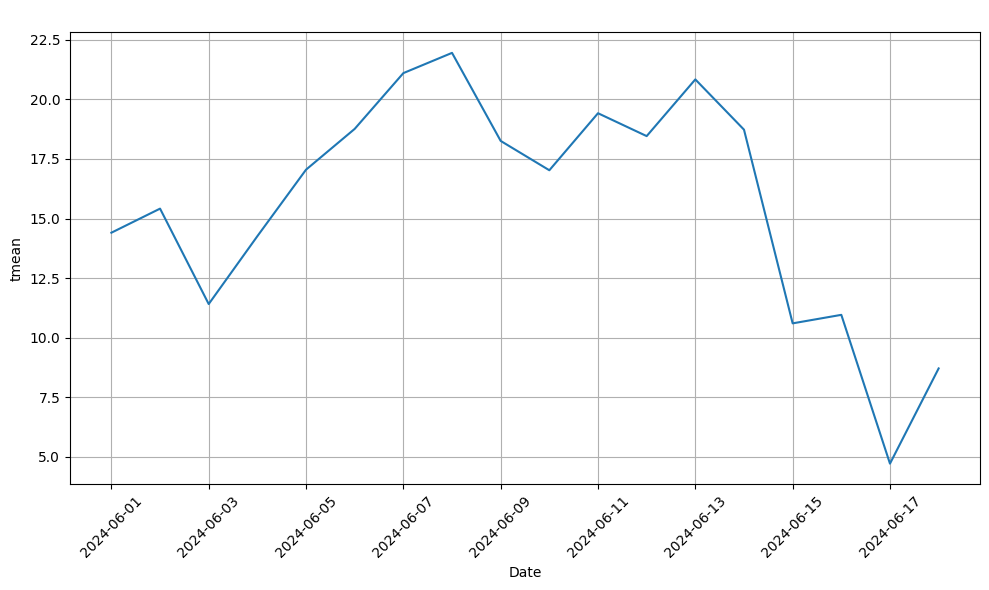

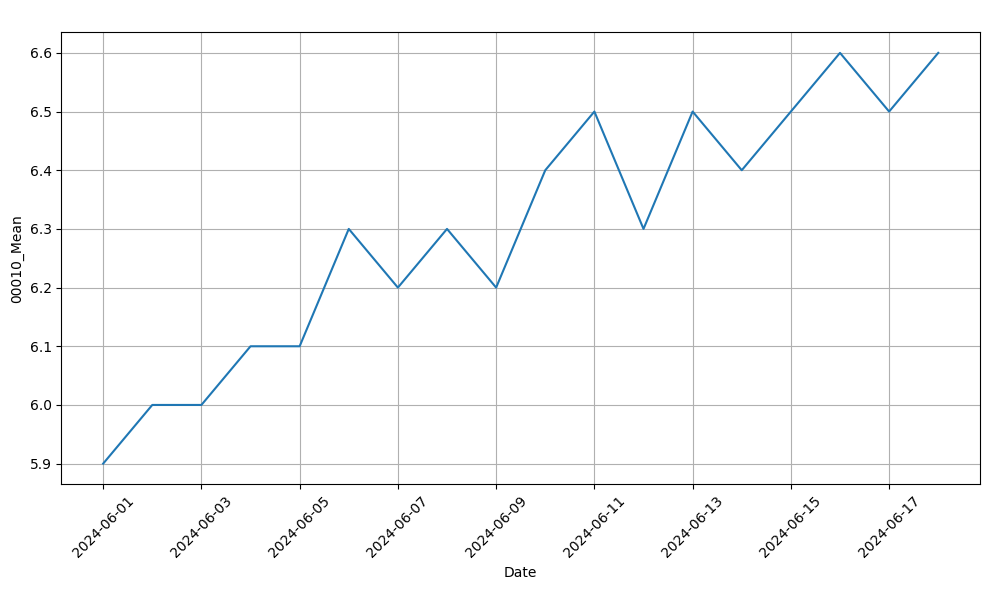

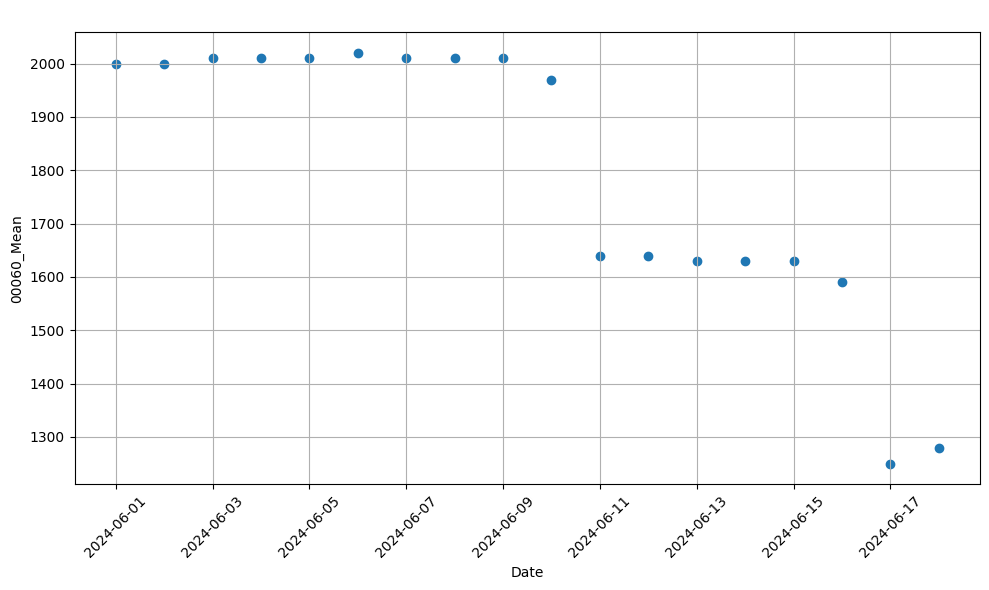

In [27]:
print(summer_df.info())
print(summer_df.head())

# --- prep ---
#summer_df['Date'] = summer_df.to_datetime( subset_rows['Date'])      # make sure Date is datetime
summer_df = summer_df.sort_values('Date').reset_index(drop=True)

# --- locate the peak bias ---
idx_peak   = summer_df['bias'].idxmin()             # row index of the max bias
date_peak  = summer_df.at[idx_peak, 'Date']         # corresponding date

# ------- OPTION 1: ±12 *days* around that date -------
start_day  = date_peak - pd.Timedelta(days=12)
end_day    = date_peak + pd.Timedelta(days=12)

subset_days = summer_df[(summer_df['Date'] >= start_day) & ( summer_df['Date'] <= end_day)].copy()

# ------- OPTION 2: ±12 *rows* around that row index -------
start_idx  = max(idx_peak - 12, 0)
end_idx    = min(idx_peak + 12, len(df) - 1)

subset_rows = summer_df.loc[start_idx : end_idx].copy()
subset_rows


# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows['bias'])

# Customizing the plot
plt.title('Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Bias')
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = 'tmean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00010_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00060_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030